![Logo UOC](https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/logotips/logo-UOC-2linies.png)

# TFG - Inteligencia Artificial
Enero de 2026

## Predicción de Respuesta a Tratamientos Oncológicos Basada en el Perfil Genético Mediante Técnicas de Aprendizaje Automático (ML) e Identificación de Genes Candidatos a Biomarcador Usando Técnicas de Explicabilidad (XAI) y Cuantificación de la Incertidumbre (UQ)

---

#### Pablo Vázquez Rodríguez
##### Grado en Ingeniería Informática
##### Inteligencia Artificial

#### Dra. María Moreno de Castro
#### Dr. Friman Sánchez

---

## Modelado (Paso 2): Entrenamiento de modelos

Como ya se comentó en el documento de exploración y preparación de datos durante el modelado se harán dos tareas:
1. Selección de características supervisada
2. Entrenamiento de modelos
3. Análisis y selección del modelo optimizado

Durante la primera tarea se realizó una selección de genes basada en modelos de regresión logística, Random Forest, XGBoost y CatBoost.

Durante la segunda tarea, se entrenarán los modelos de nuevo esta vez sobre el conjunto que contiene sólo a los genes seleccionados. Tras el entrenamiento se evaluarán para elegir el modelo óptimo, sobre el que más adelante se aplicarán técnicas de explicabilidad y cuantificación de la incertidumbre.

Durante la tercera tarea se hará un análisis de los modelos obtenidos, se valorará su rendimiento y se elegirá el modelo mejor optimizado.

## 0. Operaciones previas

### Carga de módulos necesarios

In [26]:
import pandas as pd
import numpy as np
import optuna
from optuna.visualization import (
    plot_optimization_history, plot_param_importances, plot_edf, plot_slice)
from plotly.subplots import make_subplots
import joblib
from datetime import datetime
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Configuraciones iniciales

In [2]:
# Random generator de numpy con seed para reproducibilidad en el notebook
rng_seed = 19293
rng = np.random.default_rng(seed=rng_seed)

In [3]:
# Carga de los datasets
df_full = pd.read_csv("./data/final/full_top_significance_reduced_feat.csv")
df_train = pd.read_csv("./data/final/train_reduced_feat.csv")
df_test = pd.read_csv("./data/final/test_reduced_feat.csv")
df_cal = pd.read_csv("./data/final/cal_reduced_feat.csv")
df_scaled_train = pd.read_csv("./data/final/scaled_train_reduced_feat.csv")
df_scaled_test = pd.read_csv("./data/final/scaled_test_reduced_feat.csv")
df_scaled_cal = pd.read_csv("./data/final/scaled_cal_reduced_feat.csv")

In [4]:
# VARIABLES ÚTILES

# Nombres de las columnas de genes
gene_columns = df_full.columns.difference(["Sample_id", "Response"])

### Funciones auxiliares

**train_with_cv_v2**

**NOTA**: Esta función auxiliar, train_with_cv_v2, se diferencia de la usada en el anterior notebook, train_with_cv, en que:

- Permite especificar nomber del estudio de Optuna y si se quiere guardar en una base de datos SQLite.
- Se elimina la opción de especificar el scoring y se fija en F1-Score.
- Elige de forma automática el umbral de F1 que maximiza esta métrica.

La función auxiliar permite:

- Pasar un estimador de entre Regresión Logística, Random Forest, XGBoost y CatBoost junto con la rejilla de parámetros a explorar
- Configurar el número de splits de la validación cruzada
- Definir el número de iteraciones del estudio de búsqueda de hiperparámetros
- Detener las iteraciones internas cuando llega a 50 rondas sin mejorar la métrica objetivo (AUC). Sólo en XGBoost y CatBoost
- Obtener un modelo entrenado con los mejores hiperparámetros encontrados
- **Especificar si se desea guardar el estudio en base de datos SQLite y el nombre del estudio**

Para la búsqueda de hiperparámetros se usa Optuna [https://optuna.org/] en lugar de los habituales GridSearchCV o RandomizedSearchCV. La razón es porque Optuna es mucho más eficiente, ya que optimiza la búsqueda de hiperparámetros teniendo en cuenta la información de iteraciones previas, tratando de maximizar la probabilidad de mejora de la métrica objetivo en cada iteración. (Ver: Tree-structured Parzen Estimator).

Mientras que para GridSearchCV se le pasan valores concretos a explorar en el grid, a Optuna se le pasan rangos que el algoritmo explorará. Esto permite que el algoritmo se adapte a valores más optimizados y con menos riesgo de sesgos por elección arbitraria de estos. Gracias a eso, es mucho más eficiente a la hora de explorar espacios de hiperparámetros más grandes que de otro modo serían inabarcables o requerirían de mucho tiempo y capacidad de cómputo.

Los algoritmos más pesados de los usados (XGBoost y CatBoost), en igualdad de condiciones con Optuna van mucho más rápido que los algoritmos ligeros (Regresión Logística y Random Forest). Esa ilusión es posible que se deba a que con XGBoost y CatBoost se usa early stopping, que además de mitigar problemas de sobreajuste hace que si el modelo, en iteraciones internas no mejora la métrica en 50 rondas, directamente pasa a la siguiente sin llegar a gastar todas las rondas que se hubiesen configurado para cada iteración.

In [5]:
def train_with_cv_v2(original_estimator, param_grid, X_train, y_train,
                  n_splits=5, n_trials=30, study_name="", store_study=False):
    """
    Entrena un modelo con validación cruzada y búsqueda de hiperparámetros.
    
    NOTA: Usa siempre: F1-score y selecciona el mejor umbral para maximizarlo

    Parámetros
    ----------
    original_estimator : sklearn estimator
        Modelo base (LogisticRegression, RandomForestClassifier, XGBClassifier, CatBoost)
    param_grid : dict
        Diccionario con los hiperparámetros a explorar.
    X_train : array-like
        Matriz de entrenamiento.
    y_train : array-like
        Etiquetas de entrenamiento.
    n_splits : int
        Número de folds para StratifiedKFold.
    n_trials: int
        Número de trials para optimizar hiperparámetros
    study_name: str
        Nombre del estudio de Optuna
    store_study: bool
        Indica si se desea persistir el estudio en una BD SQLite (./data/optuna_studies/studies.db)

    Return
    ------
    study_results : dict
        Diccionario con: Objeto de estudio, mejores parámetros, mejor puntuación de métrica, 
        mejor umbral de f1 y modelo entrenado con los mejores parámetros hallados
    """

    # Convertir etiquetas a enteros (por compatibilidad con todos los algoritmos usados)
    
    
    def objective(trial):
        # Construir kwargs del estimador a partir de la rejilla de parámetros
        # En base al primer elemento del espacio:
        #    "I": Espacio de enteros
        #    "F": Espacio de floats
        #    En cualquier otro caso: Espacio de categorías
        params = {}
        for name, space in param_grid.items():
            match space[0]:
                case "I":
                    params[name] = trial.suggest_int(name, min(space[1:]), max(space[1:]))
                case "F":
                    params[name] = trial.suggest_float(name, min(space[1:]), max(space[1:]))
                case _:
                    params[name] = trial.suggest_categorical(name, space[1:])

        # Clonar el estimador origen y actualizarlo con los hiperparámetros en cada iteración
        model = clone(original_estimator)
        model.set_params(**params, random_state=rng_seed)

        # Crear los folds para la validación cruzada
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng_seed)
        scores = []
        thresholds = []

        # Recorrer todos los folds de validación cruzada
        #
        # NOTA: Se tratan por separado los conjuntos de train y val de cada fold
        # para poder aprovecharse de la evaluación con early_stopping que 
        # XGBoost y CatBoost permiten definir para ahorrar creaciones de árboles 
        # innecesarias si no hay mejoras
        for train_idx, valid_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr, y_val = y_train[train_idx], y_train[valid_idx]

            # Ajuste con soporte de eval_set y early stopping
            # Si los estimadores lo permiten, se usa early stopping
            #
            # NOTA: XGBClassifier da problemas si se le pasa el parámetro
            #       early_stopping_rounds en el fit, así que hay que 
            #       tratarlo a parte
            if isinstance(model, XGBClassifier):
                model.set_params(early_stopping_rounds=50)
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            elif isinstance(model, CatBoostClassifier):
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, 
                          verbose=False)
            else:
                # Modelos que no soportan early stopping
                model.fit(X_tr, y_tr)


            # Evaluar y devolver el mejor valor de F1 según umbral óptimo en cada caso
            # Se obtienen las "probabilidades" del modelo sobre el set de validación
            y_proba = model.predict_proba(X_val)[:, 1]
            # Se calcula el F1 del modelo para todos los umbrales (de 0 a 100)
            candidate_thresholds = np.linspace(0, 1, 101)
            f1_per_threshold = [f1_score(y_val, (y_proba >= t).astype(int)) for t in candidate_thresholds]
            # Se selecciona el umbral con mayor F1
            best_idx = np.argmax(f1_per_threshold)
            # Se acumula el mejor F1 usando el umbral óptimo sobre el modelo
            scores.append(f1_per_threshold[best_idx])
        
        # Devolver F1-Score medio que Optuna trata de optimizar
        return np.mean(scores)

    # Crear estudio y optimizar
    if store_study:
        storage_path = "sqlite:///./data/optuna_studies/studies.db"
        study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_path)
    else:
        study = optuna.create_study(study_name=study_name, direction="maximize")
    
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_score = study.best_value
    best_f1_threshold = study.best_trial.user_attrs.get("avg_threshold", None)

    # Reentrenar con los mejores hiperparámetros y todos los datos de train
    best_model = clone(original_estimator)
    best_model = best_model.set_params(**best_params, random_state=rng_seed)

    if isinstance(best_model, (XGBClassifier, CatBoostClassifier)):       
        best_model.fit(X_train, y_train, verbose=False)
    else:
        best_model.fit(X_train, y_train)

    # Obtener el mejor threshold de F1 para el mejor modelo
    y_proba = best_model.predict_proba(X_train)[:, 1]
    candidate_thresholds = np.linspace(0, 1, 101)
    f1_per_threshold = [f1_score(y_train, (y_proba >= t).astype(int)) for t in candidate_thresholds]
    best_f1_threshold = candidate_thresholds[np.argmax(f1_per_threshold)]

    study_results = {
        "study": study,
        "best_params": best_params,
        "best_score": best_score,
        "best_f1_threshold": best_f1_threshold,
        "best_model": best_model
    }
    
    return study_results

### Modelado

In [23]:
# Datos de entrenamiento
X_train = df_scaled_train.drop(columns=["Response", "Sample_id"])
y_train_orig = df_scaled_train["Response"]

# Datos de test
X_test = df_scaled_test.drop(columns=["Response", "Sample_id"])
y_test_orig = df_scaled_test["Response"]

# Datos de calibración
X_cal = df_scaled_cal.drop(columns=["Response", "Sample_id"])
y_cal_orig = df_scaled_cal["Response"]

# Para simplificar el modelado con la función auxiliar, se decide en este punto
# transformar Response de Categórica a 0/1

# Clases objetivo a 0/1: Non_response=0, Response=1
le = LabelEncoder()
y_train = le.fit_transform(y_train_orig)
y_test = le.fit_transform(y_test_orig)
y_cal = le.fit_transform(y_cal_orig)

# Mostrar mapeo de clases
for i, label in enumerate(le.classes_): print(f"{i}: {label}")

0: Non_response
1: Response


In [7]:
# NOTA: Esta celda tarda alrededor de 3 minutos en el hardware original usado
# Modelo de Regresión logística para selección de genes

# Fecha y hora de la ejecución (para que los nombres de estudio siempre sean únicos)
now = datetime.now().isoformat()
study_name = f"{now}_best_logreg_model_study"

# Estimador
log_reg = LogisticRegression(penalty="elasticnet", solver="saga", max_iter=5000, class_weight="balanced")

# Rangos de hiperparámetros
log_reg_param_grid = {
    "C": ["F", 0.01, 10],
    "l1_ratio": ["F", 0.1, 0.9],
}

# Entrenamiento con validación cruzada
log_reg_results = train_with_cv_v2(
    log_reg, log_reg_param_grid, X_train, y_train,
    n_splits=5, n_trials=150, study_name=study_name, store_study=True)

print(f"\nEstudio: {study_name}"
    f"\nMejores parámetros: {log_reg_results["best_params"]}", 
    f"\nMejor F1-Score: {log_reg_results["best_score"]}")

[I 2025-11-27 20:02:17,347] A new study created in RDB with name: 2025-11-27T20:02:16.860770_best_logreg_model_study
[I 2025-11-27 20:02:18,447] Trial 0 finished with value: 0.5966764012692285 and parameters: {'C': 1.4415654589998301, 'l1_ratio': 0.8874634406484578}. Best is trial 0 with value: 0.5966764012692285.
[I 2025-11-27 20:02:19,513] Trial 1 finished with value: 0.5974191032469727 and parameters: {'C': 9.522657107155627, 'l1_ratio': 0.482433562668119}. Best is trial 1 with value: 0.5974191032469727.
[I 2025-11-27 20:02:20,503] Trial 2 finished with value: 0.5974191032469727 and parameters: {'C': 6.780710099094906, 'l1_ratio': 0.38685830912920605}. Best is trial 1 with value: 0.5974191032469727.
[I 2025-11-27 20:02:21,498] Trial 3 finished with value: 0.5982967405152373 and parameters: {'C': 2.7038945187620764, 'l1_ratio': 0.6496758414111675}. Best is trial 3 with value: 0.5982967405152373.
[I 2025-11-27 20:02:22,504] Trial 4 finished with value: 0.5982967405152373 and parameter


Estudio: 2025-11-27T20:02:16.860770_best_logreg_model_study
Mejores parámetros: {'C': 0.18060406163147527, 'l1_ratio': 0.3923023726101893} 
Mejor F1-Score: 0.6047920333207006


**Valores obtenidos**

**Estudio**: 2025-11-27T20:02:16.860770_best_logreg_model_study

**Mejores parámetros**: {'C': 0.18060406163147527, 'l1_ratio': 0.3923023726101893} 

**Mejor F1-Score**: 0.6047920333207006

In [16]:
# Mejor modelo de Regresión Logística
best_logreg_model = log_reg_results["best_model"]

# Guardar el mejor modelo para usarlo en posteriores análisis
# NOTA: Comentado para evitar guardados de nuevos modelos accidentalmente
#joblib.dump(best_logreg_model, "./data/best_models/best_logreg_model.joblib")

**Random Forest**

In [9]:
# NOTA: Esta celda tarda alrededor de 20 minutos en el hardware original usado
# Modelo de Regresión logística para selección de genes

# Fecha y hora de la ejecución (para que los nombres de estudio siempre sean únicos)
now = datetime.now().isoformat()
study_name = f"{now}_best_rf_model_study"

# Estimador
rf = RandomForestClassifier(class_weight="balanced", random_state=rng_seed)

# Rangos de hiperparámetros
rf_param_grid = {
    "n_estimators": ["I", 100, 500],
    "max_depth": ["I", 5, 20],
    "max_features": ["C", "sqrt", "log2"],
    "min_samples_split": ["I", 2, 10]
}

# Entrenamiento con validación cruzada
rf_results = train_with_cv_v2(
    rf, rf_param_grid, X_train, y_train, 
    n_splits=5, n_trials=150, study_name=study_name, store_study=True)

print(f"\nEstudio: {study_name}"
    f"\nMejores parámetros: {rf_results["best_params"]}", 
    f"\nMejor F1-Score: {rf_results["best_score"]}")

[I 2025-11-27 20:04:53,137] A new study created in RDB with name: 2025-11-27T20:04:53.098487_best_rf_model_study
[I 2025-11-27 20:04:57,346] Trial 0 finished with value: 0.6422481730780174 and parameters: {'n_estimators': 126, 'max_depth': 19, 'max_features': 'log2', 'min_samples_split': 7}. Best is trial 0 with value: 0.6422481730780174.
[I 2025-11-27 20:05:05,600] Trial 1 finished with value: 0.6423476682337224 and parameters: {'n_estimators': 297, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 8}. Best is trial 1 with value: 0.6423476682337224.
[I 2025-11-27 20:05:14,595] Trial 2 finished with value: 0.6468616194971315 and parameters: {'n_estimators': 345, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 9}. Best is trial 2 with value: 0.6468616194971315.
[I 2025-11-27 20:05:25,272] Trial 3 finished with value: 0.6414206758039628 and parameters: {'n_estimators': 384, 'max_depth': 17, 'max_features': 'log2', 'min_samples_split': 3}. Best is trial 2 with va


Estudio: 2025-11-27T20:04:53.098487_best_rf_model_study
Mejores parámetros: {'n_estimators': 118, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2} 
Mejor F1-Score: 0.6563895319317158


**Valores obtenidos**

**Estudio**: 2025-11-27T20:04:53.098487_best_rf_model_study

**Mejores parámetros**: {'n_estimators': 118, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2} 

**Mejor F1-Score**: 0.6563895319317158

In [18]:
# Mejor modelo de Random Forest
best_rf_model = rf_results["best_model"]

# Guardar el mejor modelo para usarlo en posteriores análisis
# NOTA: Comentado para evitar guardados de nuevos modelos accidentalmente
#joblib.dump(best_rf_model, "./data/best_models/best_rf_model.joblib")

**XGBoost**

In [11]:
# NOTA: Esta celda tarda alrededor de 6 minutos en el hardware original usado
# Modelo de Regresión logística para selección de genes

# Fecha y hora de la ejecución (para que los nombres de estudio siempre sean únicos)
now = datetime.now().isoformat()
study_name = f"{now}_best_xgboost_model_study"

# Ratio de balanceo (0=Non_response, 1=Response)
balance_value = (y_train==0).sum() / (y_train==1).sum()

# Estimador
xgboost = XGBClassifier(scale_pos_weight=balance_value, random_state=rng_seed)

# Rangos de hiperparámetros
xgboost_param_grid = {
    "n_estimators": ["I", 200, 1000],
    "max_depth": ["I", 4, 12],
    "learning_rate": ["F", 0.05, 0.3],
    "min_child_weight": ["I", 1, 5],
    "reg_alpha": ["I", 0, 1],
    "reg_lambda": ["I", 1, 10],
    "subsample": ["F", 0.8, 1.0],
    "colsample_bytree": ["F", 0.8, 1.0]
}

# Entrenamiento con validación cruzada
xgboost_results = train_with_cv_v2(
    xgboost, xgboost_param_grid, X_train, y_train, 
    n_splits=5, n_trials=150, study_name=study_name, store_study=True)

print(f"\nEstudio: {study_name}"
    f"\nMejores parámetros: {xgboost_results["best_params"]}", 
    f"\nMejor F1-Score: {xgboost_results["best_score"]}")

[I 2025-11-27 20:23:33,030] A new study created in RDB with name: 2025-11-27T20:23:32.991022_best_xgboost_model_study
[I 2025-11-27 20:23:36,660] Trial 0 finished with value: 0.643769640201817 and parameters: {'n_estimators': 921, 'max_depth': 9, 'learning_rate': 0.09950939142948174, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 4, 'subsample': 0.8404601923539539, 'colsample_bytree': 0.8997738595685435}. Best is trial 0 with value: 0.643769640201817.
[I 2025-11-27 20:23:38,919] Trial 1 finished with value: 0.6427808168697279 and parameters: {'n_estimators': 574, 'max_depth': 10, 'learning_rate': 0.1259423981677255, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 0.9610244010947679, 'colsample_bytree': 0.8705581260216231}. Best is trial 0 with value: 0.643769640201817.
[I 2025-11-27 20:23:40,352] Trial 2 finished with value: 0.6325506956487155 and parameters: {'n_estimators': 987, 'max_depth': 4, 'learning_rate': 0.25934693523014274, 'min_child_weight': 1, 'r


Estudio: 2025-11-27T20:23:32.991022_best_xgboost_model_study
Mejores parámetros: {'n_estimators': 664, 'max_depth': 7, 'learning_rate': 0.09355289686325986, 'min_child_weight': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8972767907569935, 'colsample_bytree': 0.9031756022599345} 
Mejor F1-Score: 0.6600449930441188


**Valores obtenidos**

**Estudio**: 2025-11-27T20:23:32.991022_best_xgboost_model_study

**Mejores parámetros**: {'n_estimators': 664, 'max_depth': 7, 'learning_rate': 0.09355289686325986, 'min_child_weight': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8972767907569935, 'colsample_bytree': 0.9031756022599345} 

**Mejor F1-Score**: 0.6600449930441188

In [15]:
# Mejor modelo de XGBoost
best_xgboost_model = xgboost_results["best_model"]

# Guardar el mejor modelo para usarlo en posteriores análisis
# NOTA: Comentado para evitar guardados de nuevos modelos accidentalmente
# joblib.dump(best_xgboost_model, "./data/best_models/best_xgboost_model.joblib")

**CatBoost**

In [13]:
# NOTA: Esta celda tarda alrededor de 7 minutos en el hardware original usado
# Modelo de Regresión logística para selección de genes

# Fecha y hora de la ejecución (para que los nombres de estudio siempre sean únicos)
now = datetime.now().isoformat()
study_name = f"{now}_best_catboost_model_study"

# Ratio de balanceo (0=Non_response, 1=Response)
balance_value = (y_train==0).sum() / (y_train==1).sum()

# Estimador
catboost = CatBoostClassifier(
    class_weights=[1, balance_value], early_stopping_rounds=50, random_state=rng_seed)

# Rangos de hiperparámetros
catboost_param_grid = {
    "iterations": ["I", 200, 1000],
    "depth": ["I", 4, 8],
    "learning_rate": ["F", 0.01, 0.3],
    "l2_leaf_reg": ["I", 1, 5],
    "rsm": ["F", 0.8, 1.0]
}

# Entrenamiento con validación cruzada
catboost_results = train_with_cv_v2(
    catboost, catboost_param_grid, X_train, y_train, 
    n_splits=5, n_trials=150, study_name=study_name, store_study=True)

print(f"\nEstudio: {study_name}"
    f"\nMejores parámetros: {catboost_results["best_params"]}", 
    f"\nMejor F1-Score: {catboost_results["best_score"]}")

[I 2025-11-27 20:28:54,145] A new study created in RDB with name: 2025-11-27T20:28:54.108985_best_catboost_model_study
[I 2025-11-27 20:28:56,227] Trial 0 finished with value: 0.642341551518789 and parameters: {'iterations': 503, 'depth': 4, 'learning_rate': 0.10545880679552186, 'l2_leaf_reg': 4, 'rsm': 0.8458257616196359}. Best is trial 0 with value: 0.642341551518789.
[I 2025-11-27 20:28:58,222] Trial 1 finished with value: 0.6312786498824557 and parameters: {'iterations': 545, 'depth': 7, 'learning_rate': 0.24145411993308102, 'l2_leaf_reg': 2, 'rsm': 0.8536061763421515}. Best is trial 0 with value: 0.642341551518789.
[I 2025-11-27 20:28:59,819] Trial 2 finished with value: 0.6372325138729447 and parameters: {'iterations': 234, 'depth': 4, 'learning_rate': 0.23282732290401273, 'l2_leaf_reg': 5, 'rsm': 0.857867045645884}. Best is trial 0 with value: 0.642341551518789.
[I 2025-11-27 20:29:03,442] Trial 3 finished with value: 0.641896075419992 and parameters: {'iterations': 932, 'depth'


Estudio: 2025-11-27T20:28:54.108985_best_catboost_model_study
Mejores parámetros: {'iterations': 420, 'depth': 6, 'learning_rate': 0.1473969376583399, 'l2_leaf_reg': 3, 'rsm': 0.9182696747233586} 
Mejor F1-Score: 0.6579436065221502


**Valores obtenidos**

**Estudio**: 2025-11-27T20:28:54.108985_best_catboost_model_study

**Mejores parámetros**: {'iterations': 420, 'depth': 6, 'learning_rate': 0.1473969376583399, 'l2_leaf_reg': 3, 'rsm': 0.9182696747233586} 

**Mejor F1-Score**: 0.6579436065221502

In [17]:
# Mejor modelo de CatBoost
best_catboost_model = catboost_results["best_model"]

# Guardar el mejor modelo para usarlo en posteriores análisis
# NOTA: Comentado para evitar guardados de nuevos modelos accidentalmente
#joblib.dump(best_catboost_model, "./data/best_models/best_catboost_model.joblib")

**A continuación se muestran algunos ejemplos que evidencian cómo Optuna va haciendo la búsqueda de hiperparámetros para CatBoost**

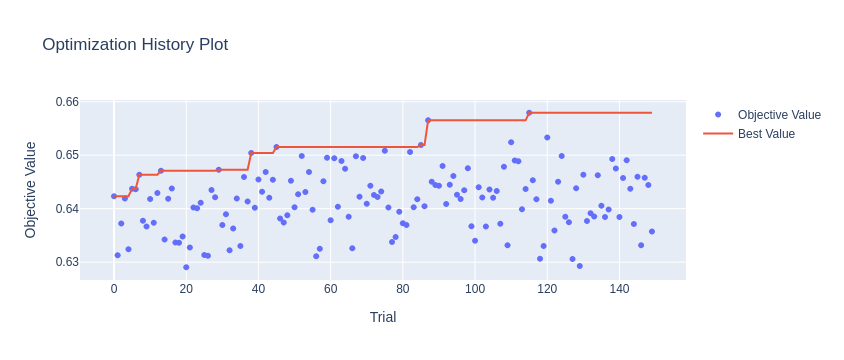

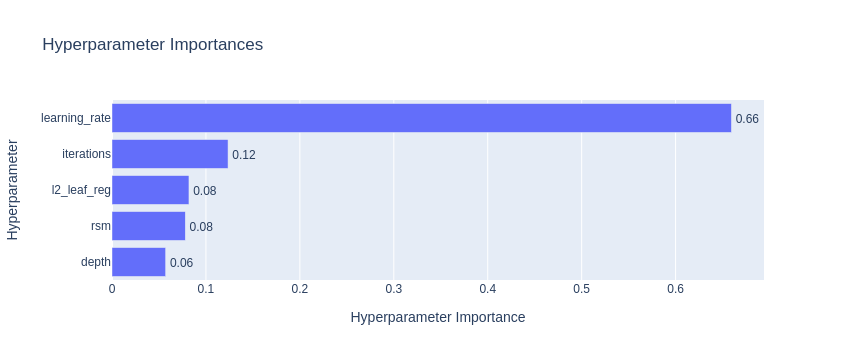

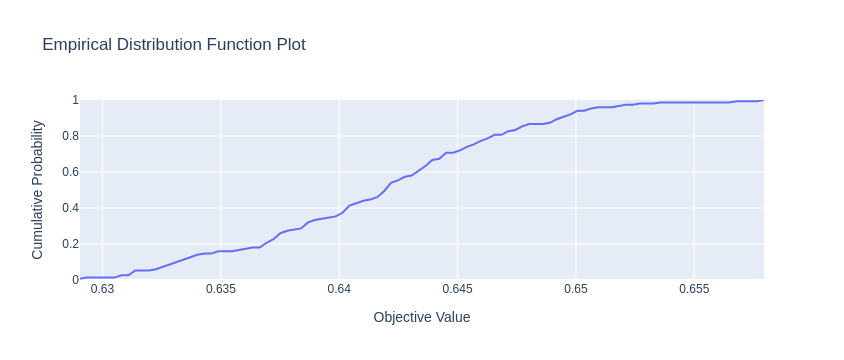

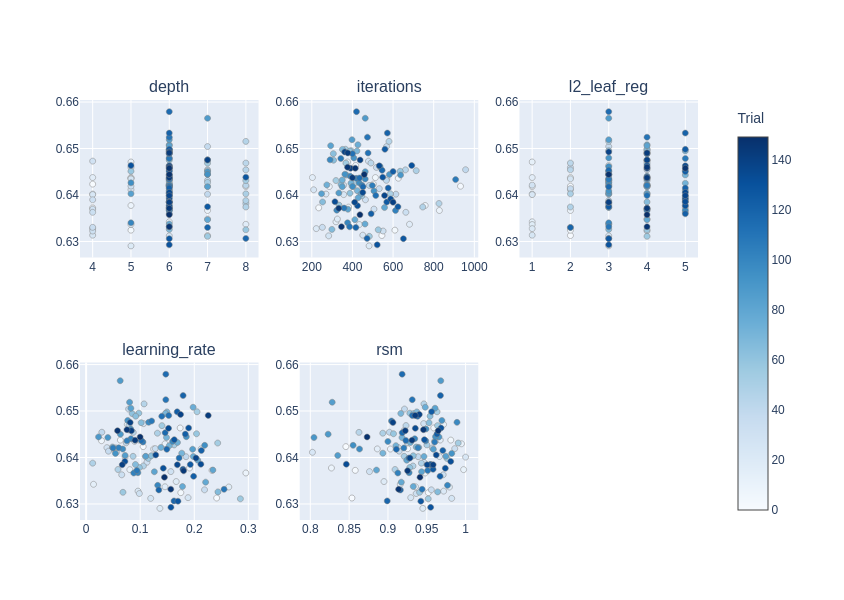

In [27]:
catboost_study = catboost_results["study"]

# Gráfico de evolución
fig1 = plot_optimization_history(catboost_study)
fig1.show()

# Gráfico de importancia de parámetros
fig2 = plot_param_importances(catboost_study)
fig2.show()

# Gráfico de coordenadas paralelas
fig3 = plot_edf(catboost_study)
fig3.show()

# Gráfico de evolución de la búsqueda de hiperparámetros
fig4 = plot_slice(catboost_study)
# Extraer títulos de los ejes X (los parámetros)
param_names = []
for key in fig4.layout:
    if key.startswith("xaxis"):
        title = getattr(fig4.layout[key].title, "text", None)
        if title:
            param_names.append(title)
param_names.sort()
# Crear una rejilla personalizada de 2 filas x 3 columnas
custom_fig = make_subplots(rows=2, cols=3, subplot_titles=param_names)

# Añadir cada trace en la rejilla
row, col = 1, 1
traces = fig4.data
for trace in traces:
    custom_fig.add_trace(trace, row=row, col=col)
    col += 1
    if col > 3:  # pasar a la siguiente fila
        col = 1
        row += 1

custom_fig.update_layout(height=600, width=800)

# Mostrar la figura
custom_fig.show()

**NOTA**: Como en este notebook hay mucha celda pesada, se procederá al análisis de los modelos en el siguiente notebook